# Weighted time series forecasting

Although historical data is available in many real use cases of forecasting, not all are reliable. Some examples of these scenarios are:

+ IoT sensors:  within the Internet of Things, sensors capture the raw data from the physical world. Often the sensors are deployed or installed in harsh environments. This inevitably means that the sensors are prone to failure, malfunction, and rapid attrition, causing the sensor to produce unusual and erroneous readings.

+ Factory shutdown: every certain period of operation, factories need to be shut down for repair, overhaul, or maintenance activities. These events cause production to stop, generating a gap in the data.

+ Pandemic (Covid-19): the Covid 19 pandemic changed population behavior significantly, directly impacting many time series such as production, sales, and transportation.

The presence of unreliable or unrepresentative values in the data history is a major problem, as it hinders model learning. For most forecasting algorithms, removing that part of the data is not an option because they require the time series to be complete. An alternative solution is to reduce the weight of the affected observations during model training. This document shows two examples of how **skforecast** makes it easy to apply this strategy.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4;">

<p class="title">
    <i class="fa-circle-exclamation fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

In the following examples, a portion of the time series is excluded from model training by giving it a weight of zero. However, the use of weights is not limited to including or excluding observations, but to balancing the degree of influence of each observation in the forecasting model. For example, an observation with a weight of 10 has 10 times more impact on the model training than an observation with a weight of 1.

</div>

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition warning" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

In most gradient boosting implementations (LightGBM, XGBoost, CatBoost), samples with zero weight are ignored when calculating the gradients and hessians. However, the feature values for those samples are still considered when building the feature histograms. Therefore, the resulting model may differ from the model trained without the zero-weighted samples. See more details in this [issue](https://github.com/microsoft/LightGBM/issues/5553).

</div>

## Libraries

In [43]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

## Data

Power plants used to generate energy are very complex installations that require a high level of maintenance. It is common that, every certain period of operation, the plant has to be shut down for repair, overhaul, or maintenance activities. The following data set contains a simulation of these events where energy production drops.

In [44]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
       'data/energy_production_shutdown.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.head()

,production
date,
2012-01-01,375.1
2012-01-02,474.5
2012-01-03,573.9
2012-01-04,539.5
2012-01-05,445.4


In [45]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Dates test       : 2014-01-01 00:00:00 --- 2014-12-30 00:00:00  (n=364)


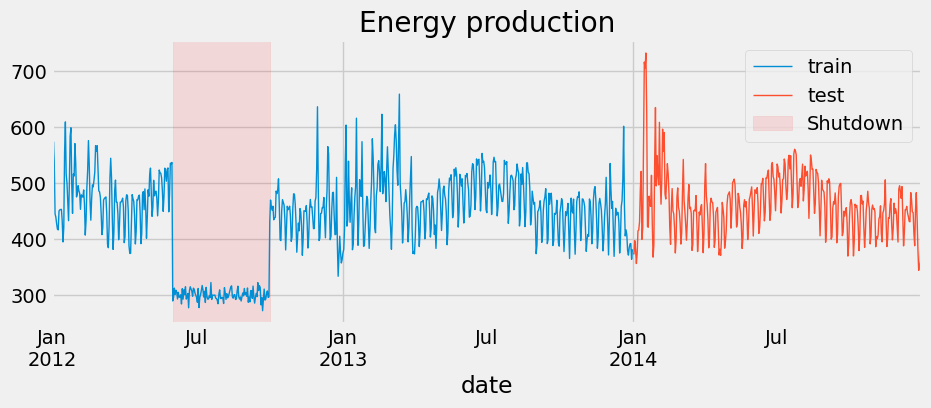

In [46]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3.5))
data_train.production.plot(ax=ax, label='train', linewidth=1)
data_test.production.plot(ax=ax, label='test', linewidth=1)
ax.axvspan(
    pd.to_datetime('2012-06'),
    pd.to_datetime('2012-10'), 
    label="Shutdown",
    color="red",
    alpha=0.1
)
ax.set_title('Energy production')
ax.legend();

## Exclude part of the time series

The factory shutdown took place from 2012-06-01 to 2012-09-30. To minimize the influence on the model of these dates, a custom function is created that gives a value of 0 if the index date is within the shutdown period or 21 days later (lags used by the model) and 1 otherwise. If an observation has a weight of 0, it does not influence the model training.

In [47]:
# Custom function to create weights
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is one between 2012-06-01 and 2012-10-21.
    """
    weights = np.where(
                  (index >= '2012-06-01') & (index <= '2012-10-21'),
                   0,
                   1
              )

    return weights

Again, a `ForecasterAutoreg` is trained but this time including the `custom_weights` function.

In [48]:
# Create Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor   = Ridge(random_state=123),
                 lags        = 21,
                 weight_func = custom_weights
             )

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`.

In [49]:
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is one between 2012-06-01 and 2012-10-21.
    """
    weights = np.where(
                (index >= '2012-06-01') & (index <= '2012-10-21'),
                0,
                1

              )
    return weights



Once the forecaster is created, a [backtesting process](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) is run to simulate its behavior if the test set had been predicted in 12-day batches.

In [50]:
# Backtesting: predict 10 days
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.production,
                                   initial_train_size = len(data.loc[:end_train]),
                                   fixed_train_size   = False,
                                   steps              = 12,
                                   metric             = 'mean_absolute_error',
                                   refit              = False,
                                   verbose            = False
                               )

print(f"Backtest error: {metric}")
predictions_backtest.head()

Backtest error: 26.821189403467883


,pred
2014-01-01,406.122211
2014-01-02,444.103631
2014-01-03,469.424876
2014-01-04,449.407001
2014-01-05,414.945674


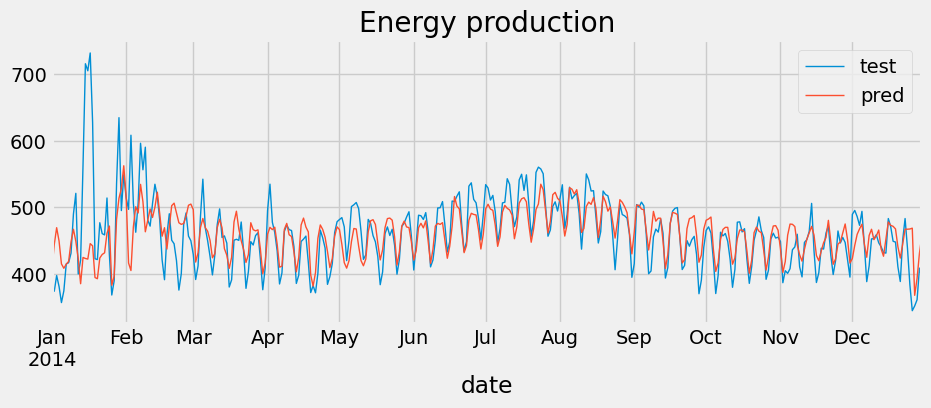

In [51]:
# Predictions plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3.5))
data_test.production.plot(ax=ax, label='test', linewidth=1)
predictions_backtest.plot(ax=ax, label='predictions', linewidth=1)
ax.set_title('Energy production')
ax.legend();

In [52]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>